# Decision Trees

In this assignment you will implement a Decision Tree algorithm as learned in class.

## In this exercise you will perform the following:
1. Practice OOP in python.
2. Implement two impurity measures: Gini and Entropy.
3. Construct a decision tree algorithm.
4. Prune the tree to achieve better results.
5. Visualize your results.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# make matplotlib figures appear inline in the notebook
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## Warmup - OOP in python

Our desicion tree will be implemented using a dedicated python class. Python classes are very similar to classes in Java.


You can use the following [site](https://jeffknupp.com/blog/2014/06/18/improve-your-python-python-classes-and-object-oriented-programming/) to learn about classes in python.

In [2]:
class Node(object):
    def __init__(self, data):
        self.data = data
        self.children = []

    def add_child(self, node):
        self.children.append(node)

In [3]:
n = Node(5)
p = Node(6)
q = Node(7)
n.add_child(p)
n.add_child(q)
n.children

[<__main__.Node at 0x7fe518856d60>, <__main__.Node at 0x7fe518856880>]

## Data preprocessing

For the following exercise, we will use a dataset containing mushroom data `agaricus-lepiota.csv`. 

This data set includes descriptions of hypothetical samples corresponding to 23 species of gilled mushrooms in the Agaricus and Lepiota Family. Each species is identified as definitely edible, definitely poisonous, or of unknown edibility and not recommended. This latter class was combined with the poisonous
one (=there are only two classes **edible** and **poisonous**). 
    
The dataset contains 8124 observations with 22 features:
1. cap-shape: bell=b,conical=c,convex=x,flat=f,knobbed=k,sunken=s
2. cap-surface: fibrous=f,grooves=g,scaly=y,smooth=s
3. cap-color: brown=n,buff=b,cinnamon=c,gray=g,green=r,pink=p,purple=u,red=e,white=w,yellow=y
4. bruises: bruises=t,no=f
5. odor: almond=a,anise=l,creosote=c,fishy=y,foul=f, musty=m,none=n,pungent=p,spicy=s
6. gill-attachment: attached=a,descending=d,free=f,notched=n
7. gill-spacing: close=c,crowded=w,distant=d
8. gill-size: broad=b,narrow=n
9. gill-color: black=k,brown=n,buff=b,chocolate=h,gray=g,green=r,orange=o,pink=p,purple=u,red=e,white=w,yellow=y
10. stalk-shape: enlarging=e,tapering=t
11. stalk-root: bulbous=b,club=c,cup=u,equal=e,rhizomorphs=z,rooted=r
12. stalk-surface-above-ring: fibrous=f,scaly=y,silky=k,smooth=s
13. stalk-surface-below-ring: fibrous=f,scaly=y,silky=k,smooth=s
14. stalk-color-above-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
15. stalk-color-below-ring: brown=n,buff=b,cinnamon=c,gray=g,orange=o,pink=p,red=e,white=w,yellow=y
16. veil-type: partial=p,universal=u
17. veil-color: brown=n,orange=o,white=w,yellow=y
18. ring-number: none=n,one=o,two=t
19. ring-type: cobwebby=c,evanescent=e,flaring=f,large=l,none=n,pendant=p,sheathing=s,zone=z
20. spore-print-color: black=k,brown=n,buff=b,chocolate=h,green=r,orange=o,purple=u,white=w,yellow=y
21. population: abundant=a,clustered=c,numerous=n,scattered=s,several=v,solitary=y
22. habitat: grasses=g,leaves=l,meadows=m,paths=p,urban=u,waste=w,woods=d

First, we will read and explore the data using pandas and the `.read_csv` method. Pandas is an open source library providing high-performance, easy-to-use data structures and data analysis tools for the Python programming language.

In [4]:
# load dataset
data = pd.read_csv('agaricus-lepiota.csv')

One of the advantages of the Decision Tree algorithm is that almost no preprocessing is required. However, finding missing values is always required.

In [5]:
count=sum(data.isna().sum())
if count>0:
    print("There is missing values in the data")
else:
    print("There isnt missing values in the data")

There isnt missing values in the data


We will split the dataset to `Training` and `Testing` datasets.

In [6]:
from sklearn.model_selection import train_test_split
# Making sure the last column will hold the labels
X, y = data.drop('class', axis=1), data['class']
X = np.column_stack([X,y])
# split dataset using random_state to get the same split each time
X_train, X_test = train_test_split(X, random_state=99)

print("Training dataset shape: ", X_train.shape)
print("Testing dataset shape: ", X_test.shape)

Training dataset shape:  (6093, 22)
Testing dataset shape:  (2031, 22)


## Impurity Measures

Impurity is a measure of how often a randomly chosen element from the set would be incorrectly labeled if it was randomly labeled according to the distribution of labels in the subset. Implement the functions `calc_gini` and `calc_entropy`. You are encouraged to test your implementation (10 points).

In [7]:
def calc_gini(data):
    """
    Calculate gini impurity measure of a dataset.
 
    Input:
    - data: any dataset where the last column holds the labels.
 
    Returns the gini impurity.    
    """
    gini = 0.0
    p_count = (data[:, -1] == 'p').sum()
    e_count = (data[:, -1] == 'e').sum()
    s=data.shape[0]
    
    gini=1-((e_count/s)**2+(p_count/s)**2)
    return gini

In [8]:
def calc_entropy(data):
    """
    Calculate the entropy of a dataset.

    Input:
    - data: any dataset where the last column holds the labels.

    Returns the entropy of the dataset.    
    """
    entropy = 0.0
    p_count = (data[:, -1] == 'p').sum()
    e_count = (data[:, -1] == 'e').sum()
    s=data.shape[0]
    
    if e_count==0 and p_count==0:
        entropy=0
        return entropy
    
    if e_count==0 or p_count==0:
        if e_count==0:
            entropy=-(p_count/s)*np.log2((p_count/s))
        else:
            entropy=-(e_count/s)*np.log2((e_count/s))
    else:
        entropy=-(e_count/s)*np.log2((e_count/s))-(p_count/s)*np.log2((p_count/s))

    return entropy

In [9]:
calc_gini(X), calc_entropy(X)

(0.4995636322379775, 0.9993703627906085)

## Goodness of Split

Given a feature the Goodnees of Split measures the reduction in the impurity if we split the data according to the feature.
$$
\Delta\varphi(S, A) = \varphi(S) - \sum_{v\in Values(A)} \frac{|S_v|}{|S|}\varphi(S_v)
$$

NOTE: you can add more parameters to the function and you can also add more returning variables (The given parameters and the given returning variable should not be touch). (10 Points)

In [10]:
def goodness_of_split(data, feature, impurity_func,gain_ratio=False):
    """
    Calculate the goodness of split of a dataset given a feature and impurity function.

    Input:
    - data: any dataset where the last column holds the labels.
    - feature: the feature index.
    - impurity func: a function that calculates the impurity.

    Returns the goodness of split.
    """

    goodness=0
    S=data.shape[0]
    data_new=data[:,[feature,-1]]
    sum_Qv=0
    Qs=impurity_func(data_new)
    if len(list(np.unique(data_new[:,0])))==1 or len(list(np.unique(data_new[:,1])))==1:
        goodness=0
        return goodness    
    else:
        for cat in list(np.unique(data_new[:,0])):
            temp_data=data_new[data_new[:,0]==cat]
            Sv=len(temp_data[:,0])
            cat_impurity=impurity_func(temp_data)
            prop=Sv/S
            sum_Qv+=prop*cat_impurity
      
    if gain_ratio : 
        p = np.unique(data[:,feature],return_counts=True)[1]/len(data)
        split_info = -np.sum(p*np.log2(p))
        goodness = (Qs-sum_Qv)/ split_info
    else:
        goodness = Qs-sum_Qv
    
    return goodness    

In [11]:
goodness_of_split(X,14,calc_entropy)

0

In [12]:
##Sanity test##
# check- example in class with target as p/e 
table = np.array([['D1', 'Sunny', 'Hot', 'High', 'Weak', 'p'],
                 ['D2', 'Sunny', 'Hot', 'High', 'Strong', 'p'],
                 ['D3', 'Overcast', 'Hot', 'High', 'Weak', 'e'],
                 ['D4', 'Rain', 'Mild', 'High', 'Weak', 'e'],
                 ['D5', 'Rain', 'Cool', 'Normal', 'Weak', 'e'],
                 ['D6', 'Rain', 'Cool', 'Normal', 'Strong', 'p'],
                 ['D7', 'Overcast', 'Cool', 'Normal', 'Strong', 'e'],
                 ['D8', 'Sunny', 'Mild', 'High', 'Weak', 'p'],
                 ['D9', 'Sunny', 'Cool', 'Normal', 'Weak', 'e'],
                 ['D10', 'Rain', 'Mild', 'Normal', 'Weak', 'e'],
                 ['D11', 'Sunny', 'Mild', 'Normal', 'Strong', 'e'],
                 ['D12', 'Overcast', 'Mild', 'High', 'Strong', 'e'],
                 ['D13', 'Overcast', 'Hot', 'Normal', 'Weak', 'e'],
                 ['D14', 'Rain', 'Mild', 'High', 'Strong', 'p']])

print("wind IG:",goodness_of_split(table,4,calc_entropy)) 
print("humidity IG:",goodness_of_split(table,3,calc_entropy)) 
print("temperture IG:",goodness_of_split(table,2,calc_entropy)) 

print("day IG:",goodness_of_split(table,0,calc_entropy)) 
print("outlook IG:",goodness_of_split(table,1,calc_entropy))

wind IG: 0.04812703040826949
humidity IG: 0.15183550136234159
temperture IG: 0.02922256565895487
day IG: 0.9402859586706311
outlook IG: 0.24674981977443933


## Building a Decision Tree

Use a Python class to construct the decision tree. Your class should support the following functionality:

1. Initiating a node for a decision tree. You will need to use several class methods and class attributes and you are free to use them as you see fit. We recommend that every node will hold the feature and value used for the split and its children.
2. Your code should support both Gini and Entropy as impurity measures. 
3. The provided data includes categorical data. In this exercise, when splitting a node create the number of children needed according to the attribute unique values.

Complete the class `DecisionNode`. The structure of this class is entirely up to you. 

Complete the function `build_tree`. This function should get the training dataset and the impurity as inputs, initiate a root for the decision tree and construct the tree according to the procedure you learned in class. (30 points)

In [13]:
class DecisionNode:
    """
    This class will hold everything you require to construct a decision tree.
    The structure of this class is up to you. However, you need to support basic 
    functionality as described above. It is highly recommended that you 
    first read and understand the entire exercise before diving into this class.
    """
    
    def __init__(self, feature,samples,value,M_class,is_leave):
        self.feature = feature # column index of criteria being tested
        self.samples = samples # How many instances were relevant
        self.value = value # How many belong to each class
        self.M_class = M_class #Decision of the majority
        self.is_leave = is_leave #1 - leave, 0-not leave
        self.children= []
        self.values = []
            
    def add_child(self, node):
        self.children.append(node)
        
    def add_value(self, value):
        self.values.append(value)

    def set_is_leave(self):
        self.is_leave = 1
    
    def get_is_leave(self):
        return self.is_leave
    
    def get_M_class(self):
        return self.M_class
    
    def get_children(self):
        return self.children

In [14]:
def build_tree(data, impurity, min_samples_split=1, max_depth=1000,gain_ratio=False):
    """
    Build a tree using the given impurity measure and training dataset. 
    You are required to fully grow the tree until all leaves are pure. 

    Input:
    - data: the training dataset.
    - impurity: the chosen impurity measure. Notice that you can send a function
                as an argument in python.
    - min_samples_split: the minimum number of samples required to split an internal node
    - max_depth: the allowable depth of the tree

    Output: the root node of the tree.
    """
    root = None
    
    def calculate_samples_value_and_M_class(data):
        samples=data.shape[0]
        p_count = (data[:, -1] == 'p').sum()
        e_count = (data[:, -1] == 'e').sum()
        value=[p_count,e_count]
        if p_count>e_count:
            M_class='p'
        else:
            M_class='e'
        return(samples,value,M_class)
    
    def split_node(node,data,max_depth,impurity,gain_ratio):
        samples,value,M_class=calculate_samples_value_and_M_class(data)
        node.samples=samples
        node.value=value
        node.M_class=M_class        
        
        if data.shape[0] < min_samples_split or max_depth==0:
            node.set_is_leave()
            return
    
        feat_num=data.shape[0]
        best_feat_idx= None
        best_feat_gop= float('-inf')
        
        for feat_idx in range(data.shape[1]-1):
            gop_feat=goodness_of_split(data,feat_idx,impurity,gain_ratio)
            if best_feat_gop<gop_feat:
                best_feat_idx=feat_idx
                best_feat_gop=gop_feat
        
        if best_feat_gop==0:
            node.set_is_leave()
            return

        if best_feat_idx is None:
            node.set_is_leave()
            return

        node.feature=best_feat_idx
        
        for cat in list(np.unique(data[:,best_feat_idx])):
            temp_data=data[data[:,best_feat_idx]==cat]
            child_node=DecisionNode(None,None,None,None,0)
            node.add_child(child_node)
            node.add_value(cat)
            split_node(child_node, temp_data, max_depth-1,impurity,gain_ratio)

            
    root = DecisionNode(None, None,None,None,0)
    split_node(root,data,max_depth,impurity,gain_ratio)
    return root

In [15]:
##Sanity test##

def print_tree(node, depth=1):
    indent = "  " * depth
    if node.is_leave: 
        print(indent + "Feature " + str(node.feature) + ":")
        print(indent + "Samples: " + str(node.samples))
        print(indent + "Value: " + str(node.value))
        print(indent + "Majority Class: " + str(node.M_class))
        print(indent + "Is Leaf: " + str(node.is_leave))
    else:
        print(indent + "Feature " + str(node.feature) + ":")
        print(indent + "Samples: " + str(node.samples))
        print(indent + "Value: " + str(node.value))
        print(indent + "Majority Class: " + str(node.M_class))
        print(indent + "Is Leaf: " + str(node.is_leave))
        for child in node.children:
            print_tree(child, depth + 1)

tree = build_tree(data=table[:,1:], impurity=calc_entropy,max_depth=2, gain_ratio=False) # gini and goodness of split
print_tree(tree)

  Feature 0:
  Samples: 14
  Value: [5, 9]
  Majority Class: e
  Is Leaf: 0
    Feature None:
    Samples: 4
    Value: [0, 4]
    Majority Class: e
    Is Leaf: 1
    Feature 3:
    Samples: 5
    Value: [2, 3]
    Majority Class: e
    Is Leaf: 0
      Feature None:
      Samples: 2
      Value: [2, 0]
      Majority Class: p
      Is Leaf: 1
      Feature None:
      Samples: 3
      Value: [0, 3]
      Majority Class: e
      Is Leaf: 1
    Feature 2:
    Samples: 5
    Value: [3, 2]
    Majority Class: p
    Is Leaf: 0
      Feature None:
      Samples: 3
      Value: [3, 0]
      Majority Class: p
      Is Leaf: 1
      Feature None:
      Samples: 2
      Value: [0, 2]
      Majority Class: e
      Is Leaf: 1


In [16]:
# python supports passing a function as an argument to another function.
tree_gini = build_tree(data=X_train, impurity=calc_gini) # gini and goodness of split
tree_entropy = build_tree(data=X_train, impurity=calc_entropy) # entropy and goodness of split
tree_entropy_gain_ratio = build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True) # entropy and gain ratio

## Tree evaluation

Complete the functions `predict` and `calc_accuracy`. (10 points)

In [17]:
def predict(node, instance):
    """
    Predict a given instance using the decision tree
 
    Input:
    - root: the root of the decision tree.
    - instance: an row vector from the dataset. Note that the last element 
                of this vector is the label of the instance.
 
    Output: the prediction of the instance.
    """
    pred = None
    if node.get_is_leave():
        return (node.get_M_class())
    
    else:
        feat=node.feature
        rel_cat=instance[feat]
        if pd.isnull(rel_cat):
            return (node.get_M_class())
        else:
            child_indice = [i for i, element in enumerate(node.values) if element == rel_cat]
            if len(child_indice)==0:
                return (node.get_M_class())
            next_node=node.children[child_indice[0]]
            return(predict(next_node, instance))

In [18]:
def calc_accuracy(node, dataset):
    """
    Predict a given dataset using the decision tree
 
    Input:
    - node: a node in the decision tree.
    - dataset: the dataset on which the accuracy is evaluated
 
    Output: the accuracy of the decision tree on the given dataset (%).
    """
    accuracy = 0
    pred=np.array([])
    rows_num=dataset.shape[0]
    for row_idx in range(rows_num):
        instance=dataset[row_idx]
        pred = np.append(pred, predict(node, instance))
    
    accuracy=sum(pred==dataset[:,-1])/rows_num
    return accuracy 

After building the three trees using the training set, you should calculate the accuracy on the test set. For each tree print the training and test accuracy. Select the tree that gave you the best test accuracy. For the rest of the exercise, use that tree (when you asked to build another tree use the same impurity function and same gain_ratio flag). 

In [19]:
calc_accuracy(tree_entropy,X_train), calc_accuracy(tree_gini,X_train),calc_accuracy(tree_entropy_gain_ratio,X_train)

(0.9940915805022157, 0.9924503528639422, 0.9963892991957984)

In [20]:
calc_accuracy(tree_entropy,X_test), calc_accuracy(tree_gini,X_test),calc_accuracy(tree_entropy_gain_ratio,X_test)

(0.7725258493353028, 0.7749876907927129, 0.7853274249138356)

**The best model is tree_entropy_gain_ratio (accuracy 0.7853274249138356)**

## Depth pruning

(15 points)

Consider the following max_depth values: [1, 2, 3, 4, 5, 6, 7, 8]. For each value, construct a tree and prune it according to the max_depth value = don't let the tree to grow beyond this depth. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the max_depth. Mark the best result on the graph with red circle.

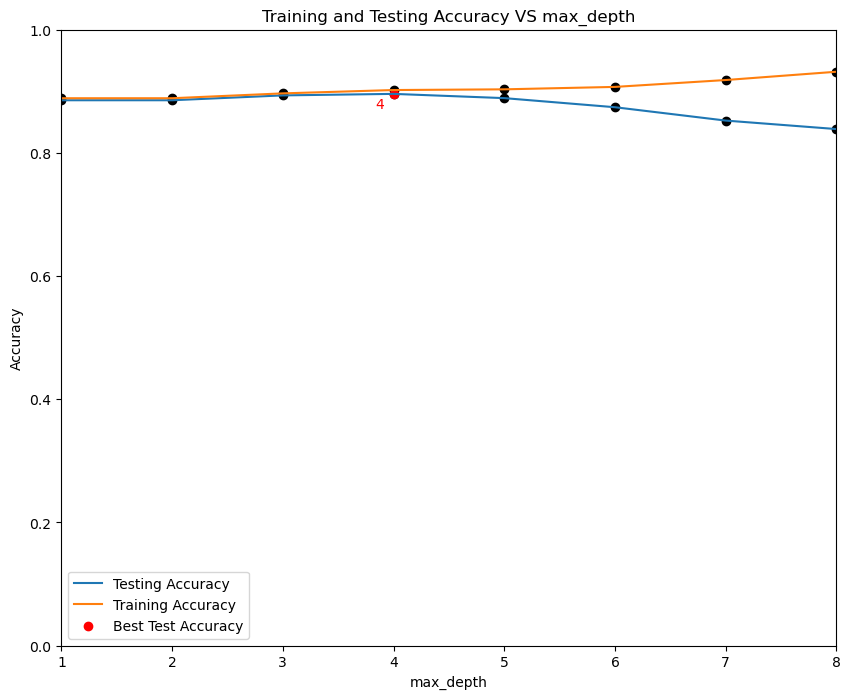

In [21]:
accuracy_dict = {}
best_accuracy = 0
best_depth = 0

for max_depth in [1, 2, 3, 4, 5, 6, 7, 8] : 
    tree=build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True,max_depth=max_depth)
    accuracy_test=calc_accuracy(tree,X_test)
    accuracy_dict[max_depth] = (accuracy_test,calc_accuracy(tree,X_train))

    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        best_depth = max_depth

# Plot
depths = list(accuracy_dict.keys())
test_accuracies = [accuracy_dict[depth][0] for depth in depths]
train_accuracies = [accuracy_dict[depth][1] for depth in depths]

plt.plot(depths, test_accuracies, label='Testing Accuracy')
plt.plot(depths, train_accuracies, label='Training Accuracy')

plt.scatter(depths, test_accuracies, color='black')
plt.scatter(depths, train_accuracies, color='black')

##best point
plt.scatter(best_depth, best_accuracy, color='red', marker='o', label='Best Test Accuracy')
plt.annotate(f'{best_depth}', (best_depth, best_accuracy), textcoords="offset points", xytext=(-10, -10), ha='center', color='red')

plt.xlabel('max_depth')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy VS max_depth')
plt.legend()
plt.xlim(1, 8)
plt.ylim(0, 1)
plt.show()


## Min Samples Split

(15 points)

Consider the following min_samples_split values: [1, 5, 10, 20, 50]. For each value, construct a tree and prune it according to the min_samples_split value = don't split a node if the number of sample in it is less or equal to the min_samples_split value. Next, calculate the training and testing accuracy.<br>
On a single plot, draw the training and testing accuracy as a function of the min_samples_split. Mark the best result on the graph with red circle. (make sure that the x-axis ticks represent the values of min_samples_split)

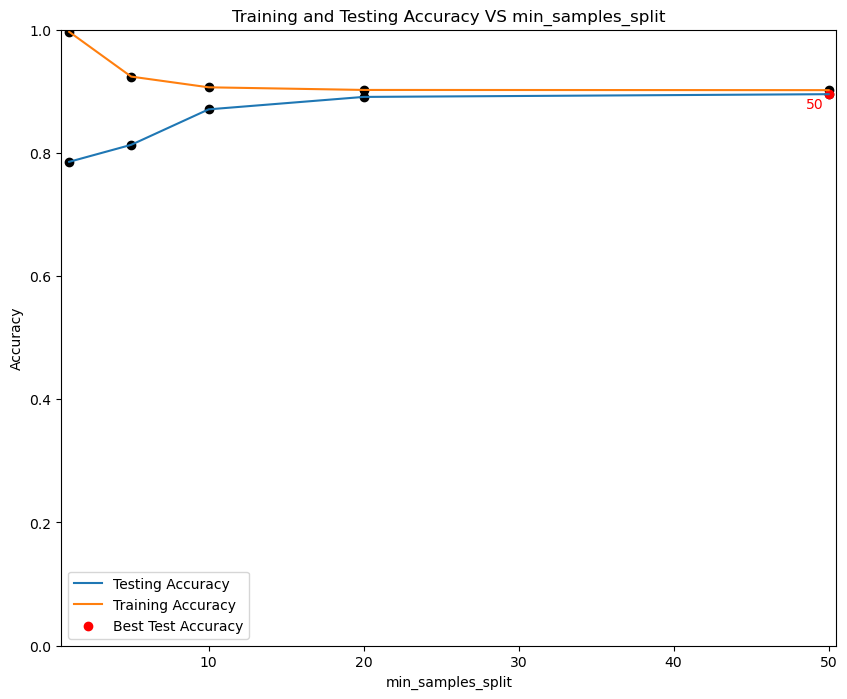

In [22]:
accuracy_dict = {}
best_accuracy = 0
best_min_samples_split = 0

for min_samples_split in [1, 5, 10, 20, 50] : 
    tree=build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True,min_samples_split=min_samples_split)
    accuracy_test=calc_accuracy(tree,X_test)
    accuracy_dict[min_samples_split] = (accuracy_test,calc_accuracy(tree,X_train))

    if accuracy_test > best_accuracy:
        best_accuracy = accuracy_test
        best_min_samples_split = min_samples_split
        
# Plot
min_samples = list(accuracy_dict.keys())
test_accuracies = [accuracy_dict[min_sample][0] for min_sample in min_samples]
train_accuracies = [accuracy_dict[min_sample][1] for min_sample in min_samples]

plt.plot(min_samples, test_accuracies, label='Testing Accuracy')
plt.plot(min_samples, train_accuracies, label='Training Accuracy')
plt.scatter(min_samples, test_accuracies, color='black')
plt.scatter(min_samples, train_accuracies, color='black')

# Best point
plt.scatter(best_min_samples_split, best_accuracy, color='red', marker='o', label='Best Test Accuracy')
plt.annotate(f'{best_min_samples_split}', (best_min_samples_split, best_accuracy), textcoords="offset points", xytext=(-10, -10), ha='center', color='red')

plt.xlabel('min_samples_split')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy VS min_samples_split')
plt.legend()
plt.xlim(0.5, 50.5) 
plt.ylim(0, 1)
plt.show()

Build the best 2 trees:
1. tree_max_depth - the best tree according to max_depth pruning
1. tree_min_samples_split - the best tree according to min_samples_split pruning

In [23]:
tree_max_depth=build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True,max_depth=4)
tree_min_samples_split=build_tree(data=X_train, impurity=calc_entropy, gain_ratio=True,min_samples_split=50)

## Number of Nodes

(5 points)

Complete the function counts_nodes and print the number of nodes in each tree and print the number of nodes of the two trees above

In [24]:
def count_nodes(node):
    """
    Count the number of node in a given tree
 
    Input:
    - node: a node in the decision tree.
 
    Output: the number of node in the tree.
    """
    if node.is_leave:
        return 1
    else:
        count = 1  # Include the current node in the count
        for child in node.children:
            count += count_nodes(child)
        return count

In [25]:
max_depth_nodes=count_nodes(tree_max_depth)
min_samples_nodes=count_nodes(tree_min_samples_split)

print("The number of nodes of tree_max_depth:",max_depth_nodes)
print("The number of nodes of tree_min_samples_split:",min_samples_nodes)

The number of nodes of tree_max_depth: 205
The number of nodes of tree_min_samples_split: 349


## Print the tree

Complete the function `print_tree`. Your tree should be visualized clearly. You can use the following example as a reference:
```
[ROOT, feature=X0],
  [X0=a, feature=X2]
    [X2=c, leaf]: [{1.0: 10}]
    [X2=d, leaf]: [{0.0: 10}]
  [X0=y, feature=X5], 
    [X5=a, leaf]: [{1.0: 5}]
    [X5=s, leaf]: [{0.0: 10}]
  [X0=e, leaf]: [{0.0: 25, 1.0: 50}]
```
In each brackets:
* The first argument is the parent feature with the value that led to current node
* The second argument is the selected feature of the current node
* If the current node is a leaf, you need to print also the labels and their counts

(5 points)

In [26]:
# you can change the function signeture
def print_tree(node, depth=0, parent_feature='ROOT', feature_val='ROOT'):
    '''
    prints the tree according to the example above

    Input:
    - node: a node in the decision tree

    This function has no return value
    '''
    indent = '  ' * depth
    feature=node.feature
    if parent_feature=='ROOT':
        print(f"[{parent_feature},feature=X{feature}],")
        for index, child in enumerate(node.children):
            feature_val=node.values[index]
            parent_feature=node.feature
            print_tree(child,depth=depth+1,parent_feature=parent_feature,feature_val=feature_val)

    elif node.get_is_leave():
        p_count=node.value[0]
        e_count=node.value[1]
        print(f"{indent}[X{parent_feature}={feature_val},leaf]: [{{'p': {p_count}, 'e': {e_count}}}]")
    
    else:
        feature=node.feature
        print(f"{indent}[X{parent_feature}={feature_val}, feature=X{feature}]")
        for index, child in enumerate(node.children):
            feature_val=node.values[index]
            parent_feature=node.feature
            print_tree(child,depth=depth+1,parent_feature=parent_feature,feature_val=feature_val)

print the tree with the best test accuracy and with less than 50 nodes (from the two pruning methods)

In [27]:
calc_accuracy(tree_max_depth,X_test),calc_accuracy(tree_min_samples_split,X_test)

(0.8956179222058099, 0.8951255539143279)

In [28]:
calc_accuracy(tree_max_depth,X_test)>calc_accuracy(tree_min_samples_split,X_test)

True

**tree_max_depth is the tree with the best test accuracy**

In [29]:
print_tree(tree_max_depth)

[ROOT,feature=X4],
  [X4=a, feature=X2]
    [X2=n, feature=X8]
      [X8=n, feature=X19]
        [X19=s,leaf]: [{'p': 3, 'e': 4}]
        [X19=y,leaf]: [{'p': 0, 'e': 8}]
      [X8=p, feature=X0]
        [X0=f,leaf]: [{'p': 1, 'e': 2}]
        [X0=x,leaf]: [{'p': 0, 'e': 7}]
      [X8=w, feature=X18]
        [X18=k,leaf]: [{'p': 1, 'e': 5}]
        [X18=n,leaf]: [{'p': 0, 'e': 7}]
    [X2=w, feature=X6]
      [X6=c, feature=X8]
        [X8=g,leaf]: [{'p': 1, 'e': 22}]
        [X8=k,leaf]: [{'p': 4, 'e': 22}]
        [X8=n,leaf]: [{'p': 1, 'e': 26}]
        [X8=w,leaf]: [{'p': 1, 'e': 16}]
      [X6=w,leaf]: [{'p': 0, 'e': 21}]
    [X2=y, feature=X6]
      [X6=c, feature=X8]
        [X8=g,leaf]: [{'p': 2, 'e': 24}]
        [X8=k,leaf]: [{'p': 1, 'e': 22}]
        [X8=n,leaf]: [{'p': 7, 'e': 28}]
        [X8=p,leaf]: [{'p': 0, 'e': 14}]
        [X8=w,leaf]: [{'p': 5, 'e': 33}]
      [X6=w, feature=X0]
        [X0=f,leaf]: [{'p': 1, 'e': 7}]
        [X0=x,leaf]: [{'p': 3, 'e': 5}]
  [X4=c